## Making training data sets
This ipython notebook provides an interactive overview to the make_training_data.py script that converts annotated images into training data sets. Our starting point is that an image (phase.png and nuclear.png) and its annotation (feature_0.png - edges and feature_1.png - interior) be present in the same folder. Our ending point will be a list of all the pixels from the image that we will sample to create our training data.

First lets load all of the python packages that we will need.

In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from cnn_functions import format_coord as cf
from skimage import morphology as morph
import skimage as sk
import scipy as sp
from scipy import ndimage
from skimage import feature
from cnn_functions import get_image
import glob, os, fnmatch
from skimage import io
import time
import random

ModuleNotFoundError: No module named 'theano'

We first have to define some parameters - the maximum number of training examples we want to sample from the image and the size of the patches sampled from our images. The window_size variables depict the number of pixels sampled from both directions to create one training image. For example, if the window_size is 30, the size of the sampled image will be 2*30+1 = 61 pixels.

In [15]:
max_training_examples = 10000000
window_size_x = 30
window_size_y = 30
print(window_size_x, window_size_y)

(30, 30)


Next we need to define the directories where the training data is located. In this example, we will train on images of 3T3 cells. We've annotated 3 images and would like to use all 3. Note that the channel_names variable contains a list of all the channels that will be loaded. The channel names must be present in the names of the image files for the program to load them.

In [16]:
direc_name = '/home/amandap/data/deepCellData/sets'
file_name_save = os.path.join('/home/amandap/data/deepCellData/training_data_npz/', 'AT22LA_all_61x61.npz')
patch_name_save = os.path.join(direc_name, 'patch_rois/cells')
patch_name_save_temp=os.path.join(direc_name, 'patch_temp/')
patch_name_save_mask=os.path.join(direc_name, 'patch_rois/cytomasks/')
training_direcs = ["m05s01set00", "m05s01set02", "m05s01set04", "m05s01set06", 
                   "m05s07set01", "m05s07set03", "m05s07set05", "m05s07set07", 
                   "m54s03set01", "m54s03set03", "m54s03set05", "m54s03set07", 
                   "m54s07set00", "m54s07set02", "m54s07set04", "m54s07set06"
                  ] 
channel_names = ["img", "nuc"]
print(direc_name)
print(patch_name_save)
print(file_name_save)
print(patch_name_save_mask)

/home/amandap/data/deepCellData/sets
/home/amandap/data/deepCellData/sets/patch_rois/cells
/home/amandap/data/deepCellData/training_data_npz/AT22LA_all_61x61.npz
/home/amandap/data/deepCellData/sets/patch_rois/cytomasks/


We also need to specify the number of features (cell edges and cell interior) that we have annotated. Furthermore, we need to identify which features are edges and whether we want to augment those edges with a dilation operation (https://en.wikipedia.org/wiki/Dilation_%28morphology%29).

In [17]:
num_of_features = 2
feature_names=["cyto", "edge"]
dil_radius = 1
print(feature_names)

['cyto', 'edge']


Next we need to get a list of all the files in the training directories and initialize some variables.

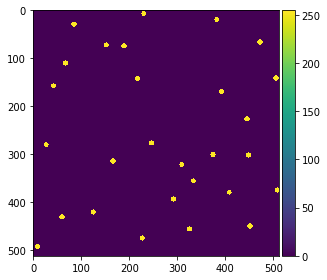

In [18]:
num_direcs = len(training_direcs)
num_channels = len(channel_names)

imglist = []
for direc in training_direcs:
	imglist += os.listdir(os.path.join(direc_name, direc))

# Load one file to get image sizes
img_temp = get_image(os.path.join(direc_name,training_direcs[0],imglist[0]))
image_size_x, image_size_y = img_temp.shape

# Initialize arrays for the training images and the feature masks
channels = np.zeros((num_direcs, num_channels, image_size_x, image_size_y), dtype='float32')
feature_mask = np.zeros((num_direcs, num_of_features + 1, image_size_x, image_size_y))

io.imshow(img_temp)

This next block of code is responsible for loading all of the images, normalizing the training data, augmenting the edges by morphological dilation (if chosen) and constructing a feature map for the background.

In [19]:
t=time.time()
# Load training images
direc_counter = 0
for direc in training_direcs:
    imglist = os.listdir(os.path.join(direc_name, direc))
    channel_counter = 0

    # Load channels
    for channel in channel_names:
        for img in imglist: 
            if fnmatch.fnmatch(img, r'*' + channel + r'*'):
                channel_file = img
                channel_file = os.path.join(direc_name, direc, channel_file)
                channel_img = get_image(channel_file) 
            # Normalize the images
            '''
                if channel == 'img':
                    p50 = np.percentile(channel_img, 50)
                    channel_img /= p50
                    print(p50)
                    avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
                    channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size
                else:
                    channel_img /= np.amax(channel_img)
                    print(np.amax(channel_img))

                channels[direc_counter,channel_counter,:,:] = channel_img
                channel_counter += 1
                print(channel_counter)
            '''

                
    # Load feature mask
    for j in xrange(num_of_features):
        feat = feature_names[j]
        for img in imglist:
            if fnmatch.fnmatch(img, r'*' + feat + r'*'):
                feature_file = os.path.join(direc_name, direc, img)
                feature_img = get_image(feature_file)
                #normalize to 1
                '''
                if np.sum(feature_img) > 0:
                    feature_img /= np.amax(feature_img)
                '''
                if feat == "edge":
                    strel = sk.morphology.disk(dil_radius)
                    feature_img = sk.morphology.binary_dilation(feature_img, 
                                                                selem = strel)
                feature_mask[direc_counter,j,:,:] = feature_img

    # Thin the augmented edges by subtracting the interior features.
    for j in xrange(num_of_features):
        feat=feature_names[j]
        if feat == "edge":
            for k in xrange(num_of_features):
                #featk=feature_names[k]
                if feat == "cyto":
                    feature_mask[direc_counter,j,:,:] -= feature_mask[direc_counter,k,:,:]
            feature_mask[direc_counter,j,:,:] = feature_mask[direc_counter,j,:,:] > 0

    # Compute the mask for the background
    feature_mask_sum = np.sum(feature_mask[direc_counter,:,:,:], axis = 0)
    feature_mask[direc_counter,num_of_features,:,:] = 1 - feature_mask_sum
    direc_counter += 1

print(time.time()-t, ' seconds elapsed')

(0.17388391494750977, ' seconds elapsed')


Plot the training data to double check that it's loaded. If you're running the script on a server, this part may need to be commented out in the make_training_data.py script.

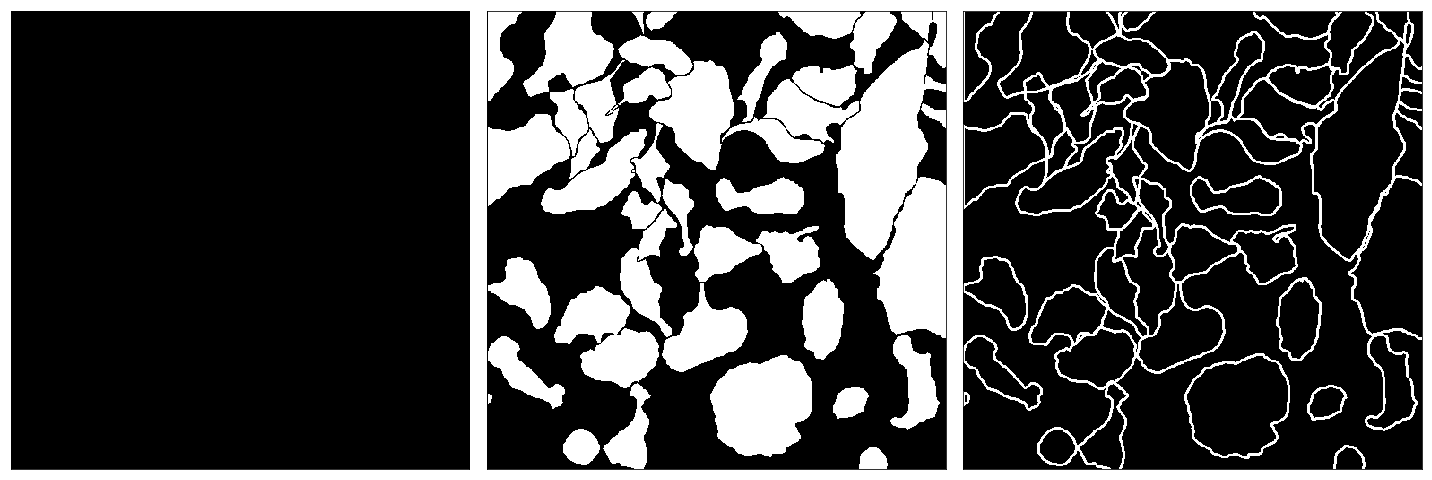

In [25]:
a=range(len(training_direcs))
if len(a)>=5:
    fig,ax = plt.subplots(1,num_of_features+1, squeeze = False, figsize=(20,10))
    for j in xrange(1):
        img_num=random.choice(a)
        a.remove(img_num)
        '''normalize for viewing
        channel_img=channels[img_num,0,:,:]
        p50 = np.percentile(channel_img, 50)
        channel_img /= p50
        avg_kernel = np.ones((2*window_size_x + 1, 2*window_size_y + 1))
        channel_img -= ndimage.convolve(channel_img, avg_kernel)/avg_kernel.size
        '''
        ax[j,0].imshow(channels[img_num,0,:,:],
                       cmap=plt.cm.gray,
                       interpolation='nearest'
                      )
        def form_coord(x,y):
            return cf(x,y,channels[j,0,:,:])
        ax[j,0].format_coord = form_coord
        ax[j,0].axes.get_xaxis().set_visible(False)
        ax[j,0].axes.get_yaxis().set_visible(False)

        for k in xrange(1,num_of_features+1):
            ax[j,k].imshow(feature_mask[img_num,k-1,:,:],cmap=plt.cm.gray,interpolation='nearest')
            def form_coord(x,y):
                return cf(x,y,feature_mask[j,k-1,:,:])
            ax[j,k].format_coord = form_coord
            ax[j,k].axes.get_xaxis().set_visible(False)
            ax[j,k].axes.get_yaxis().set_visible(False)
else:
    fig,ax = plt.subplots(len(training_direcs),num_of_features+1, squeeze = False)
    for j in xrange(len(training_direcs)):
        ax[j,0].imshow(channels[j,0,:,:],cmap=plt.cm.gray,interpolation='nearest')
        def form_coord(x,y):
            return cf(x,y,channels[j,0,:,:])
        ax[j,0].format_coord = form_coord
        ax[j,0].axes.get_xaxis().set_visible(False)
        ax[j,0].axes.get_yaxis().set_visible(False)

        for k in xrange(1,num_of_features+1):
            ax[j,k].imshow(feature_mask[j,k-1,:,:],cmap=plt.cm.gray,interpolation='nearest')
            def form_coord(x,y):
                return cf(x,y,feature_mask[j,k-1,:,:])
            ax[j,k].format_coord = form_coord
            ax[j,k].axes.get_xaxis().set_visible(False)
            ax[j,k].axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

We've written this code to sample equally from each training image present. We first identify the feature that has the fewest examples (typically edges) and then we identify which training set has the smallest number of pixels in that feature category. We need to find the training data set with the least number of edge pixels. We then sample that number of pixels from each of the training data sets (if possible)

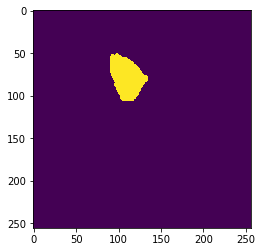

In [21]:
img=plt.imread('/home/jacobk/lifeact_data/patches/mask/WellE06_Seq0031t15xy25c1_shift080_2_roi013.png')
plt.imshow(img)

Once we know how many pixels to sample, we can identify which pixels to sample from the training data. The identity of each pixel requires 3 values - which row (feature_rows), which column (feature_cols) and which training image (feature_batch). The values of all 3 are saved as arrays with the corresponding names.

In [26]:
print(img_num)

10


Finally, we clip the number of training examples so that it is less than the maximum number of allowed training examples. We also randomly shuffle the order of the training examples.

Finally, lets save the training data as an npz file.

# save patches to use on @jkimmel's cellsegnet architecture

In [31]:
training_data = np.load('/home/amandap/data/deepCellData/training_data_npz/AT22LA_all_61x61_2.npz')
channels = training_data["channels"]
batch = training_data["batch"]
labels = training_data["y"]
pixels_x = training_data["pixels_x"]
pixels_y = training_data["pixels_y"]
win_x = training_data["win_x"]
win_y = training_data["win_y"]

(16, 2, 512, 512)
(16, 3, 512, 512)
[[   0.    0.    0. ...,    0.    0.    0.]
 [   0.  255.  255. ...,  255.  255.  255.]
 [   0.  255.  255. ...,  255.  255.  255.]
 ..., 
 [   0.  255.  255. ...,    0.    0.    0.]
 [   0.  255.  255. ...,    0.    0.    0.]
 [   0.  255.  255. ...,    0.    0.    0.]]


255.0

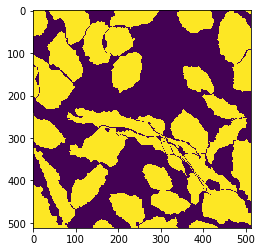

In [32]:
print(channels.shape)
print(feature_mask.shape)
print(feature_mask[0,0])
plt.imshow(feature_mask[0, 0, :,:])
np.amax(feature_mask[0,0,:,:])

In [33]:
for b, x, y, l in zip(batch, pixels_x, pixels_y, labels):
    img = channels[b,0, x-win_x:x+win_x+1, y-win_y:y+win_y+1]
    #mask=feature_mask[b,0, x-win_x:x+win_x+1, y-win_y:y+win_y+1]
    #img=np.arange(61*61).reshape((61,61))
    #print(img.shape)
    #img=img.astype('i4')
    #print(img.dtype)
    img_name='Batch%s_X%s_Y%s_L%s.tif'%(b, x, y, l)
    file_name=os.path.join(patch_name_save, img_name)
    #mask_name='Batch%s_X%s_Y%s_L%s_mask.tif'%(b, x, y, l)
    #mask_file=os.path.join(patch_name_save_mask, mask_name)
    #print(file_name)
    io.imsave(file_name, img)
    #io.imsave(mask_file, mask)
    #counter+=1
    #if counter ==2:
    #    break

In [51]:
print(counter)
print(len(batch))
print(len(pixels_x))
print(mask_file)
print(file_name)

print(batch[counter-1])
print(b, x, y, l)

430771
430771
430771
/home/amandap/data/deepCellData/sets/patch_rois/cytomasks/Batch2_X112_Y393_L2_mask.tif
/home/amandap/data/deepCellData/sets/patch_rois/cells/Batch2_X112_Y393_L2.tif
2
(2, 112, 393, 2)


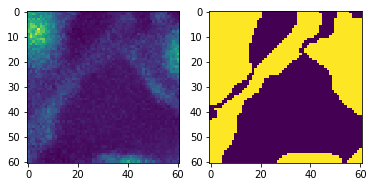

In [52]:
img = channels[b,0, x-win_x:x+win_x+1, y-win_y:y+win_y+1]
mask=feature_mask[b,0, x-win_x:x+win_x+1, y-win_y:y+win_y+1]
plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)

## save mask patches

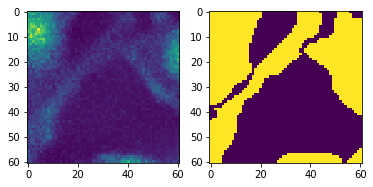

In [4]:
from skimage import io
img=io.imread('/home/amandap/data/deepCellData/sets/patch_rois/cells/Batch2_X112_Y393_L2.tif')
mask=io.imread('/home/amandap/data/deepCellData/sets/patch_rois/cytomasks/Batch2_X112_Y393_L2_mask.tif')

plt.subplot(1,2,1)
plt.imshow(img)
plt.subplot(1,2,2)
plt.imshow(mask)

In [5]:
img

array([[ 5.56258106,  4.60163736,  3.68053532, ..., -1.16135049,
        -1.28685582, -1.3724556 ],
       [ 4.42747879,  4.82911587,  5.62651157, ..., -1.21604657,
        -1.24606276, -1.37871552],
       [ 4.00222397,  4.25897598,  3.57018423, ..., -1.02189231,
        -1.20163155, -1.11007833],
       ..., 
       [ 1.31850946,  0.47054017,  0.37882531, ..., -0.51716769,
        -0.25569522, -0.011603  ],
       [ 0.41641498,  0.37442994, -0.31291783, ..., -0.25711745,
        -0.41455227,  0.62884915],
       [ 0.75104237,  0.5145123 , -0.39940596, ...,  0.31838965,
         0.24983287, -0.26327336]], dtype=float32)

In [6]:
img.mean()

-0.10498257